# Diamond EP Resolution LDA

The data's variation was previously explored using PCA. The obtained results showed some clustering, but no clear indicator of categorical separation. PCA's feature 'importance' table also disagreed with previous findings on correlation and categorically separated means tables.

Another attempt in reducing dimensionality will be done using LDA, in hopes of identifying more relevant (combinations of) features. The data was first prepared including f''.

In [1]:
import sys
dirpath = r'/home/ynk78583/PycharmProjects/Diamond_ML'
if dirpath not in sys.path:
    sys.path.insert(0, dirpath)
from read_data import x, y, union, pd, np, plt

For LDA the data needs to be grouped/categorised. Sklearn's LDA model can do this automatically if no 'y' value is provided, however we can use the success labels we already possess.

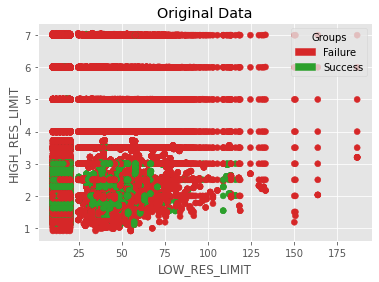

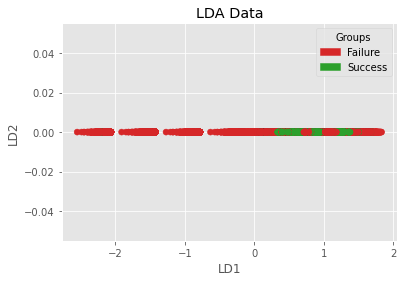

In [2]:
from matplotlib.patches import Patch
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, StandardScaler


def plot_original_data(col1_name, col2_name):
    # color each group
    cmap = {0: "tab:red", 1: "tab:green"}
    c = y.map(cmap)
    patches = [Patch(color=c, label=l) for c, l in zip(cmap.values(), ["Failure", "Success"])]

    # plot normal data
    fig, ax = plt.subplots()
    x_plot, y_plot = x.loc[:, "LOW_RES_LIMIT"], x.loc[:, "HIGH_RES_LIMIT"]

    ax.scatter(x_plot, y_plot, c=c)

    ax.set_xlabel(x_plot.name)
    ax.set_ylabel(y_plot.name)
    ax.set_title("Original Data")
    ax.legend(handles=patches, title="Groups")
    
    return (fig, ax), (cmap, c, patches)

# scale data
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x.drop("SPACEGROUP", axis=1))  # str incompatible with scaler
x_scaled = pd.DataFrame(x_scaled, index=x.index, columns=x.columns.drop("SPACEGROUP"))
x_scaled["SPACEGROUP"] = x["SPACEGROUP"].copy()

# Linear Discriminant Analysis - maximise success group separation
lda = LinearDiscriminantAnalysis()
X = x.loc[:, ["LOW_RES_LIMIT", "HIGH_RES_LIMIT"]]
x_new = lda.fit_transform(X, y)

# plot OG data
plt.style.use("ggplot")
(_, _), (cmap, c, patches) = plot_original_data("LOW_RES_LIMIT", "HIGH_RES_LIMIT")

# plot LDA transform
fig, ax = plt.subplots()
x_plot, y_plot = x_new, np.zeros_like(x_new)

ax.scatter(x_plot, y_plot, c=c)

ax.set_xlabel("LD1")
ax.set_ylabel("LD2")
ax.set_title("LDA Data")
ax.legend(handles=patches, title="Groups")

plt.show()

The above code used the **low and high resolution limits** to produce a single LD component. From the first figure, for success, the following appear to be required:

    - High resolution limit < 3.5
    - Low resolution limit < 125

LDA also does a good job of clustering the success data, which is all clustered around LD1=1.

To see if scaling is important during LDA, fitting and transforming is attempted using **total observations**, a feature with large scale compared to **high resolution limit**.

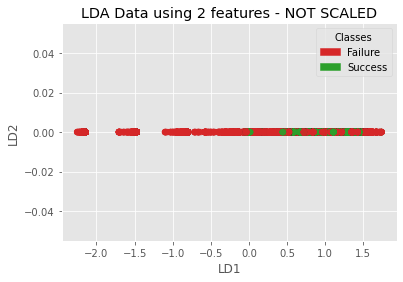

NOT SCALED:
- Coefficients: [[-7.15675611e-07 -7.17753909e-01]]
- Classes: [0. 1.]
- Means: [[9.76525801e+04 4.02341889e+00]
 [1.64082397e+05 2.36800197e+00]]



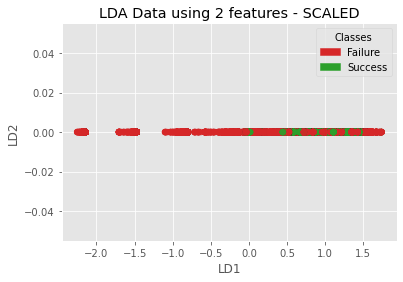

SCALED:
- Coefficients: [[-0.14519979 -1.21624302]]
- Classes: [0. 1.]
- Means: [[-0.06430685  0.19186976]
 [ 0.26311924 -0.78505833]]



In [3]:
for x_data, txt in zip((x, x_scaled), ("NOT SCALED", "SCALED")):
    # Linear Discriminant Analysis - maximise success group separation
    lda = LinearDiscriminantAnalysis()
    X = x_data.loc[:,["TOTAL_OBSERVATIONS", "HIGH_RES_LIMIT"]]
    x_new = lda.fit_transform(X, y)

    # plot LDA transform
    fig, ax = plt.subplots()
    x_plot, y_plot = x_new, np.zeros_like(x_new)

    ax.scatter(x_plot, y_plot, c=c, alpha=.5)

    ax.set_xlabel("LD1")
    ax.set_ylabel("LD2")
    ax.set_title(f"LDA Data using {X.shape[1]} features - {txt}")
    ax.legend(handles=patches, title="Classes")

    plt.show()
    
    coefs, classes, means = lda.coef_, lda.classes_, lda.means_

    print(f"{txt}:\n"
          f"- Coefficients: {lda.coef_}\n"
          f"- Classes: {lda.classes_}\n"
          f"- Means: {lda.means_}\n")

The only thing that appears to have changed are the *features coefficients* (and naturally the means). In the non-scaled case, they vary wildly (e-7 to e-1), however in the scaled case this variation is smaller.

As such, in the future, to avoid any scaling mistakes, a *pipeline using a scaler* will be used.

Now that we know to scale the data before LDA, we can attempt this on all of the features, and the resulting coefficients analysed.

In [4]:
import seaborn as sns

features = x.columns
nice_features = {i: i.lower().title() for i in features}
df_lda=[]

for feat_idx, feature in enumerate(features):
    for class_idx, class_name in enumerate(lda.classes_):
        print(lda.classes_, lda.coef_, feat_idx, feature, class_idx, class_name)
        value = abs(lda.coef_[class_idx, feat_idx])
        df_lda.append((nice_features[feature], class_name, value))
        
        
df_lda=pd.DataFrame(df_lda)
df_lda.columns=['FEATURE', 'CLASS', 'COEFFICIENT']
sns.barplot(data=df_lda, x='CLASS', hue='FEATURE', y='COEFFICIENT')
plt.legend(bbox_to_anchor=(1.01, 1))
plt.show()


order = list(df_lda.groupby(by=["FEATURE"]).COEFFICIENT.median().sort_values().index)[::-1]
sns.boxplot(data=df_lda, y='FEATURE', x='COEFFICIENT', order=order)
plt.show()

[0. 1.] [[-0.14519979 -1.21624302]] 0 DATASET_id 0 0.0
[0. 1.] [[-0.14519979 -1.21624302]] 0 DATASET_id 1 1.0


IndexError: index 1 is out of bounds for axis 0 with size 1

## LDA vs PCA

To test the effectiveness of LDA compared to PCA and no dimensionality reduction, a *KNeighbors* model was fitted to the data using the just mentioned options, just as a simple test. There were then 3 models:

- **Basic**: Scaled, no transformation, K Neighbors Classifier (5 neighbors)
- **PCA**  : Scaled, 95% variance PCA transformation, K Neighbors Classifier (5 neighbors)
- **LDA**  : Scaled, 1 component LDA transformation, K Neighbors Classifier (5 neighbors)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, recall_score, precision_score, f1_score

# create pipelines
n_neighbors = 5
n_pca = 0.95
lda = Pipeline([("scaler", StandardScaler()),
                ("lda", LinearDiscriminantAnalysis()),
                ("knn", KNeighborsClassifier(n_neighbors=n_neighbors))])
pca = Pipeline([("scaler", StandardScaler()),
                ("pca", PCA(n_components=n_pca)),
                ("knn", KNeighborsClassifier(n_neighbors=n_neighbors))])
knn = Pipeline([("scaler", StandardScaler()),
                ("knn", KNeighborsClassifier(n_neighbors=n_neighbors))])

# split data
test_size, random_state = 0.25, 3
fit_cols = ["LOW_RES_LIMIT", "HIGH_RES_LIMIT", "TOTAL_OBSERVATIONS", "TOTAL_UNIQUE_OBSERVATIONS"]
plot_cols = ["LOW_RES_LIMIT", "HIGH_RES_LIMIT"]
X = x.drop("SPACEGROUP", axis=1).loc[:, fit_cols]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)


# check if data is split correctly
atol = 0.0003  # 0.03% tolerance
test_ratio = y_test.size / y.size
print(f"Test ratio: {round(test_ratio*100, 2)} - {np.isclose(test_ratio, test_size, atol=atol)}")
total_label_ratio = y.value_counts()[1]/y.value_counts().sum()
train_label_ratio = y_train.value_counts()[1]/y_train.value_counts().sum()
test_label_ratio = y_test.value_counts()[1]/y_test.value_counts().sum()
print(f"Total 1-0 label ratio: {round(total_label_ratio*100, 2)}",
      f"Train 1-0 label ratio: {round(train_label_ratio*100, 2)} - {np.isclose(train_label_ratio, total_label_ratio, atol=atol)}",
      f"Test 1-0 label ratio: {round(test_label_ratio*100, 2)} - {np.isclose(test_label_ratio, total_label_ratio, atol=atol)}",
      sep="\n")  # test to see if data is split correctly
print("--------------------------------")


# first show entire data
x_plot, y_plot = x[plot_cols[0]], x[plot_cols[1]]
plot_original_data(x_plot, y_plot)


# show each model's predictions
for model, title in zip((knn, pca, lda), ("Basic", "PCA", "LDA")):
    # fit model to data
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    y_pred = pd.Series(y_pred, index=x_test.index, name="predictions")
    score = model.score(x_test, y_test)

    # plot predicted
    try:
        x_plot, y_plot = x_test[plot_cols[0]], x_test[plot_cols[1]]
    except KeyError:
        x_plot, y_plot = x.loc[x_test.index, plot_cols[0]], x.loc[x_test.index, plot_cols[1]]

    fig, ax = plt.subplots()
    ax.scatter(x_plot, y_plot, c=y_pred.map(cmap), alpha=.5)
    ax.legend(handles=patches, title="Classes")

    # figure text
    ax.set_xlabel(x_plot.name)
    ax.set_ylabel(y_plot.name)
    ax.set_title(f"{title} fitting test using {x_train.shape[1]} features - "
                 f"score {round(score*100, 2)}")
    
    # confusion matrix
    plot_confusion_matrix(model, x_test, y_test)
    
    # show figure & metrics for current model
    plt.show()
    print(f"{title}:\n"
          f"    Accuracy: {round(score*100, 2)}\n"
          f"    Precision: {round(precision_score(y_test, y_pred)*100, 2)}\n"
          f"    Recall: {round(recall_score(y_test, y_pred)*100, 2)}\n"
          f"    F1: {round(f1_score(y_test, y_pred)*100, 2)}")

The previous code was repeated for combinations of **low/high resolution limits** and **total (unique) observations**. The following was found in most cases when using up to 4 of these features:

- The **Basic** model did **suprisingly well**, achieving the best scores out of the 3 models in multiple occasions.
- The **PCA** dimensionality reduction occasionally showed a **slight improvement** to all metrics, however this was never larger than 1%.
- The **LDA** dimensionality reduction did not improve the model, but actually **worsened its performance**, especially when using multiple features.

The low LDA performance is likely due to the fact that, since there are only 2 categories (success or not), LDA can only transform into 1D space, removing a lot of the extra dimensionality required for this problem. A possible solution would be to use more categories, such as the spacegroups success categories previously found.

Training feature choice also had a deep impact on the model's performance.

- **Worst**: *BASIC* [Low resolution limit] - 77.55% accuracy, 33.80% precision, 14.79% recall, 20.57% f1 - too **pessimistic**
- **Best**: *BASIC* [High resolution limit, Total observations, Total unique observations] - 97.47% accuracy, 93.75%, 93.35%, 93.55% (PCA slight increase) - might be **overfitted**

From the various feature combinations' metrics, the **low resolution limit** can be said to be the **weakest feature**, at least from these 4, as can be seen from the decrease in performance when including the low resolution limit with the other 3.

On the other hand, **total (unique) observations**, and especially **high resolution limit** are **strong features** with good predictive capability. 

## Spacegroup Clustering LDA

LDA was then attempted using the 4 spacegroup clusters obtained from each one's success rate, as previously seen. First the clusters are prepared.

In [ ]:
from sklearn.cluster import KMeans
from matplotlib.patches import Patch

# create spacegroup success rate
agg_sorted = union.groupby("SPACEGROUP").agg(["mean", "sem"])\
            .sort_values(("IS_SUCCESS", "mean"), ascending=False)

# try ML grouping
n = 4
model = KMeans(n_clusters=n)
pred = model.fit_predict(pd.DataFrame(agg_sorted["IS_SUCCESS", "mean"]))
pred = pd.Series(pred, index=agg_sorted.index)

# colormaps
cmap = plt.cm.get_cmap("Dark2")
c_bar = pred.map(cmap)
c_sctr = x["SPACEGROUP"].map(c_bar)

# bar plot
fig_bar, ax_bar = plt.subplots(figsize=(12, 8))
ax_bar.bar(agg_sorted.index, agg_sorted["IS_SUCCESS", "mean"],
       yerr=agg_sorted["IS_SUCCESS", "sem"], color=c_bar)
ax_bar.hlines(y.mean(), 0, agg_sorted.index.size - 1, colors="brown", label="Mean")
ax_bar.set_title(f"Sorted Spacegroup Success Distribution with {n} groups")

# scatter plot
fig_sctr, ax_sctr = plt.subplots(figsize=(12, 8))
x_plot, y_plot = x["LOW_RES_LIMIT"], x["HIGH_RES_LIMIT"]
ax_sctr.scatter(x_plot, y_plot, c=c_sctr, alpha=.5)

# scatter labels
ax_sctr.set_xlabel(x_plot.name)
ax_sctr.set_ylabel(y_plot.name)
ax_sctr.set_title("Example of Spacegroup Clusters")

# legend
patches = [Patch(color=c, label=l) for c, l in\
           zip(c_bar.drop_duplicates(), ["High", "Average", "Low", "Null"])]
ax_bar.legend(handles=patches, title="Groups")
ax_sctr.legend(handles=patches, title="Groups")


plt.show()

Then they are ran through a scaled LDA pipeline.

In [ ]:
from sklearn.pipeline import Pipeline

# create lda pipeline
pipe = Pipeline([("scaler", StandardScaler()),
                ("lda", LinearDiscriminantAnalysis())])
lda = pipe["lda"]

# fit to data
X = x.drop("SPACEGROUP", axis=1)
x_new = pipe.fit_transform(X, y=x["SPACEGROUP"].map(pred))


# plot variance ratios
lds = {f"LD{i+1}": ratio for i, ratio in enumerate(lda.explained_variance_ratio_)}
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_ylim(0, 1.1)
ax.bar(lds.keys(), lds.values())

# add cumulative sum of explained variance ratios
evr = lda.explained_variance_ratio_
evr_sum = np.cumsum(list(evr))
ax.plot(lds.keys(), evr_sum, marker="o", c="k")

# labels
ax.set_xlabel("LD component")
ax.set_ylabel("Explained Variance Ratio")
ax.set_title(f"LDA Explained Variance Ratio using {X.shape[1]} features")
plt.show()


# plot LD1 vs LD2
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(x_new[:, 0], x_new[:, 1], c=c_sctr)
ax.legend(handles=patches, title="Groups")
ax.set_xlabel("LD1")
ax.set_ylabel("LD2")
ax.set_title(f"LDA using {X.shape[1]} features")

# use coefficients for feature importance
coefs = pd.Series(lda.coef_.sum(axis=0), index=X.columns, name="coefficients")
sorted_abs_coef = coefs.sort_values(key=lambda a: abs(a), ascending=False)

plt.show()



print("Feature Importance:\n", sorted_abs_coef, sep="\n")

Luckily, 2 LD components describe ~97% of the variance. However, when these are plotted, **the separation isn't the best**. There are clear success rate clusters, however these **overlap significantly**, and there is little clarity improvement.

The feature importance results are unexpected, if anything. They disagree with previous correlation and success-grouped difference tables. However, they do agree with the PCA feature importance table.

**RMEAS/RMERGE/R (DIFF) I** are among the best, with only **SHELXC RANOM/RPIM** above them. **(Anomalous) multiplicity/completeness** also have high importance, just like the PCA results.